# Libraries

In [177]:
import numpy as np
import torch
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch import optim
import numpy as np

# Generator

In [221]:
def generator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True)
    )

In [222]:
class Generator(nn.Module):
    def __init__(self, noise_dim, hidden_dim, image_dim):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            generator_block(noise_dim, hidden_dim),
            generator_block(hidden_dim, 2*hidden_dim),
            generator_block(2*hidden_dim, 4*hidden_dim),
            generator_block(4*hidden_dim, 8*hidden_dim),
            nn.Linear(8*hidden_dim, image_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Discriminator

In [223]:
def discriminator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(negative_slope=0.2)
    )

In [224]:
class Discriminator(nn.Module):
    def __init__(self, image_dim, hidden_dim):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            discriminator_block(image_dim, 4*hidden_dim),
            discriminator_block(4*hidden_dim, 2*hidden_dim),
            discriminator_block(2*hidden_dim, hidden_dim),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.model(x)

# Hyperparameter

In [194]:
# hyper parameter
hidden_dim = 128
noise_dim=64
image_dim=28*28
batch_size=128
lr=0.00001
epochs=200
num_images = 10
disp_freq=100


root_ds='D:\GitHub\gan-lab\Dataset'
root_bm = "D:\GitHub\gan-lab\Best_Models"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data

In [195]:
dataloader = DataLoader(
    MNIST(root_ds, download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

In [196]:
def get_noise(n_samples, noise_dim, device='cpu'):
    return torch.randn(n_samples, noise_dim, device=device)

# Training

In [197]:
# get instance from models
model_dis = Discriminator(image_dim, hidden_dim).to(device)
model_gen = Generator(noise_dim, hidden_dim, image_dim).to(device)

# Loss function
criterion=nn.BCEWithLogitsLoss()

# Optimizers
optim_dis = optim.Adam(model_dis.parameters(), lr=lr)
optim_gen = optim.Adam(model_gen.parameters(), lr=lr)

# LAB

In [198]:
loss_gen_min = np.Inf

for epoch in range(1,epochs+1):
    print(60 * "#")
    print(6 * "#" + " Epoch " + str(epoch) + " " + 45 * "#")
    print(60 * "#")

    # Set mode on "train mode"
    model_gen.train()
    model_dis.train()

    for iter_train, (x, _) in enumerate(dataloader,1):
        # GPU (model and data)
        x=x.to(device)

# Discriminator Loss / Update

        # zero grad
        optim_dis.zero_grad()

        # some fake images will generate by Generator
        x_hat = model_gen(get_noise(num_images, noise_dim, device=device))

        # Discriminator determine how fake images are Fake (With Fake images)
        y_hat_fake = model_dis(x_hat)
        loss_fake = criterion(y_hat_fake, torch.zeros_like(y_hat_fake))

        # Discriminator determine how real images are Realistic (With Real images)
        y_hat_real = model_dis(torch.flatten(x, start_dim=1))
        loss_real = criterion(y_hat_real, torch.ones_like(y_hat_real))

        # Weighted Average
        loss_dis = (x.shape[0] * loss_real + num_images * loss_fake) / (x.shape[0] + num_images)

        # Update ONLY Parameters of Discriminator
        loss_dis.backward()
        optim_dis.step()

# Generator Loss / Update

        # zero grad
        optim_gen.zero_grad()

        # some fake images will generate by Generator
        x_hat = model_gen(get_noise(num_images, noise_dim, device=device))

        # Discriminator determine how fake images are Fake (With Fake images)
        y_hat_fake = model_dis(x_hat)
        loss_gen = criterion(y_hat_fake, torch.ones_like(y_hat_fake))

        # Update ONLY Parameters of Discriminator
        loss_gen.backward()
        optim_gen.step()

# Display
        if iter_train % disp_freq ==0:
            print("iteration : {}\tLoss Dis : {:.2f}\tLoss Gen : {:.2f}".format(iter_train,loss_dis,loss_gen))

# Save Best Model
        if loss_gen <= loss_gen_min:
            filename = root_bm + '\model_epoch_{}_loss_gen_{}.pt'.format(epoch,loss_gen)
            torch.save({'state_dict': model_gen.state_dict()}, filename)
            loss_gen_min = loss_gen

############################################################
###### Epoch 1 #############################################
############################################################
iteration : 100	Loss Dis : 0.56	Loss Gen : 0.46
iteration : 200	Loss Dis : 0.44	Loss Gen : 0.14
iteration : 300	Loss Dis : 0.43	Loss Gen : 0.07
iteration : 400	Loss Dis : 0.50	Loss Gen : 0.06
############################################################
###### Epoch 2 #############################################
############################################################
iteration : 100	Loss Dis : 0.53	Loss Gen : 0.08
iteration : 200	Loss Dis : 0.50	Loss Gen : 0.10
iteration : 300	Loss Dis : 0.50	Loss Gen : 0.13
iteration : 400	Loss Dis : 0.45	Loss Gen : 0.21
############################################################
###### Epoch 3 #############################################
############################################################
iteration : 100	Loss Dis : 0.32	Loss Gen : 0.44
iteration : 200	Los

KeyboardInterrupt: 

# Test

In [218]:
model_gen.eval()
fake_images = model_gen(get_noise(25, noise_dim, device=device))

In [201]:
images=fake_images.view(-1,28,28)

In [ ]:
i=8
plt.imshow(images.to('cpu').detach().numpy()[i], cmap='gray')

In [219]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


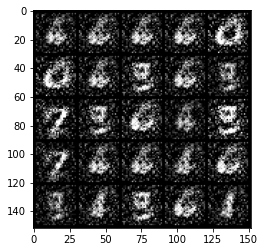

In [220]:
show_tensor_images(fake_images)

In [216]:
len(dataloader)

469